# Creating a professionality detector
One of the steps in our system is to be able to detect whether an article or a social media post is written by professional journalists or by common users. I haven't been able to find proper papers on the subject, nor freely available datasets. I have however found [this interesting project](https://www.deepnews.ai/) that tackles the problem. [Here's an article on how the project came to life](https://mondaynote.com/building-a-quality-engine-for-journalism-dd10f77ac3a9).

I'm going to use a different approach though. I'm going to retrieve articles extracted from [r/savedyouaclick](https://www.reddit.com/r/savedyouaclick), a subreddit dedicated to expose clickbait and low quality news.
Together they will form the low-quality part of the dataset.

The high-quality part of the dataset will be made of the articles that were most upvoted on some of the most reliable subreddits (like r/politics, r/news, ...)

I emailed deepnews.ai to see if they're interested in sharing their data with me to compare the two datasets, I'm waiting for their answer.

## Import

In [ ]:
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3', cache_discovery=False)

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created

In [ ]:
def upload_from_drive(link, name):
  id = link.split('file/d/')[1].split('/view?usp=sharing')[0]
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(name) 

In [ ]:
!pip install newspaper3k

     |████████████████████████████████| 215kB 5.6MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 7.4MB 9.6MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp36-none-any.whl size=13538 sha256=35305b70ac998ee5f7107d1e3108d7c0dd5290209c1501ce0e9508f196704749
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp36-none-any.whl size=7398406 sha256=1b0d7d343b5b75d93710fbb46a4b19636c3d732abef7fdce9bf1f02c8b50419e
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp36-none-any.whl size=3355 sha256=2d33e09702610a04797e41d80cb3e3b4d1e2720806c2834a15677fe2901b03a8
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7

In [ ]:
from newspaper import Article
from newspaper import Config
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = USER_AGENT

In [ ]:
!pip3 install -q tensorflow_gpu==2.3.0

     |████████████████████████████████| 320.4MB 53kB/s 


In [ ]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3MB 138kB/s 
     |████████████████████████████████| 983kB 49.8MB/s 
     |████████████████████████████████| 245kB 48.9MB/s 
     |████████████████████████████████| 1.3MB 50.7MB/s 
     |████████████████████████████████| 471kB 52.4MB/s 
     |████████████████████████████████| 1.1MB 50.9MB/s 
     |████████████████████████████████| 890kB 48.0MB/s 
     |████████████████████████████████| 2.9MB 51.1MB/s 


In [ ]:
import tensorflow as tf
import ktrain
from ktrain import text
MODEL_NAME = 'bert-base-multilingual-uncased'
print(tf.__version__)
tf.test.gpu_device_name()

2.3.0


'/device:GPU:0'

## Dataset creation
We're going to build our dataset starting from Reddit. There will be two sections, one for low-quality journalism, one for high-quality.

In [ ]:
url = "https://api.pushshift.io/reddit/search/submission"

def crawl_page(subreddit: str, sort_by: str, last_page = None):
  
  params = {"subreddit": subreddit, "size": 500, "sort": "desc", "sort_type": sort_by}
  if last_page is not None:
    if len(last_page) > 0:
      # resume from where we left at the last page
      params["before"] = last_page[-1][sort_by]
    else:
      # the last page was empty, we are past the last page
      return []
  results = requests.get(url, params)
  if not results.ok:
    # something wrong happened
    raise Exception("Server returned status code {}".format(results.status_code))
  return results.json()["data"]

def crawl_subreddit(subreddit, sort_by, submissions, max_submissions = 500000):
  
  last_page = None
  while last_page != [] and len(submissions) < max_submissions:
    try:
      last_page = crawl_page(subreddit, sort_by, last_page)
    except:
      break
    submissions += last_page
    print(str(len(submissions)) + str(" posts obtained out of ") + str(max_submissions))
    time.sleep(2)
  return submissions[:max_submissions]

### Low-quality info

In [ ]:
latest_submissions = crawl_subreddit("savedyouaclick", "created_utc")

In [ ]:
df = pd.DataFrame(latest_submissions)

In [ ]:
df.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'removed_by_category', 'retrieved_on', 'score',
       'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit',
       'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'thumbnail',
       'thumbnail_height', 

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1K00_th_MsDr5yKqfjLxz2Jw3iVf6EAc-/view?usp=sharing', 'low_quality_articles.csv')
df = pd.read_csv('low_quality_articles.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,4,6,8,9,10,11,12,16,18,19,20,21,22,24,26,27,28,29,30,31,35,37,41,45,46,51,57,60,61,63,65,66,71,73,74,77,79,81,82,84,85,86,87,93) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df['dummy'] = 1
df.groupby(by='domain').count().sort_values(by='dummy', ascending=False)['dummy'][:20]

domain
archive.is                    6337
web.archive.org               6111
self.savedyouaclick           2335
youtube.com                   1144
i.redd.it                      918
streamable.com                 570
youtu.be                       501
archive.fo                     306
unvis.it                       305
unv.is                         294
archive.today                  292
elgibbortechandconsult.com     239
express.co.uk                  172
msn.com                        156
businessinsider.com            151
i.imgur.com                    151
imgur.com                      143
cnn.com                        138
reddit.com                     133
yahoo.com                      121
Name: dummy, dtype: int64

Let's remove some domains that aren't useful

In [ ]:
domains_to_exclude = ['self.savedyouaclick', 'youtube.com', 'i.redd.it', 'streamable.com', 'youtu.be']
df = df[df['domain'].isin(domains_to_exclude) == False]

Let's scrape the articles using newspaper3k

In [ ]:
articles = []
articles_not_downloaded = []
domains = {}

def retrieveArticles(link, domain):

  article_info = {}
  article_info['url'] = link
  article_info['publisher'] = domain
  
  #To allow a faster scraping process
  if domain in domains:
    if time.time() - domains[domain] < 1:
      time.sleep(1)
  domains[domain] = time.time()

  try:
    article = Article(link, config=config)
    article.download()
    article.parse()
    article.nlp()
  except:
    print("Error with link ", link)
    articles_not_downloaded.append(article_info)
    return
  
  article_info['text'] = article.text

  global articles
  articles.append(article_info)
  print("Retrieved {0}/{1} articles ({2:.2f}%)".format(5000*(index) + len(articles), len(df), (5000*(index) + len(articles))*100/len(df)))

start_point = 5000
finish_point = len(df)
step = 5000
index = 1

while start_point < finish_point:
  df_partial = df[start_point:start_point+step]
  articles = []
  df_partial.apply(lambda row: retrieveArticles(row['url'], row['domain']), axis=1)
  pd.DataFrame(articles).to_csv('low_quality_articles' + str(index) + '.csv', index=False)
  save_file_to_drive('low_quality_articles' + str(index) + '.csv', 'low_quality_articles' + str(index) + '.csv')
  index += 1
  start_point += step

pd.DataFrame(articles_not_downloaded).to_csv('articles_not_downloaded.csv', index=False)

Error with link  http://archive.is/TbdTy
Error with link  https://archive.fo/BkbZQ
Error with link  http://archive.is/xnj9Z
Error with link  http://archive.is/B9LTk
Error with link  http://archive.is/B9LTk
Retrieved 5001/25529 articles (19.59%)
Retrieved 5002/25529 articles (19.59%)
Retrieved 5003/25529 articles (19.60%)
Error with link  http://archive.is/mUUP8
Error with link  http://archive.is/9rB6p
Error with link  https://archive.is/u3tmk
Error with link  http://archive.is/ssGHe
Error with link  https://archive.is/iPS0G
Error with link  http://web.archive.org/save/https://moneyversed.com/ellen-degeneres-hair/?as=705aol&amp;bdk=b705aol&amp;ch=bt
Retrieved 5004/25529 articles (19.60%)
Error with link  http://archive.is/5FzFH
Retrieved 5005/25529 articles (19.61%)
Retrieved 5006/25529 articles (19.61%)
Retrieved 5007/25529 articles (19.61%)
Error with link  http://web.archive.org/man-adopts-small-puppy-but-thats-not-a-dog-at-all?utm_source=snapchat&amp;utm_medium=cpc&amp;utm_campaign=

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname CDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Retrieved 5629/25529 articles (22.05%)
Error with link  http://archive.is/IdgQ6
Error with link  https://unv.is/ibtimes.com/nasa-asteroid-tracker-near-earth-object-taller-pyramids-will-skim-earth-today-2796234
Retrieved 5630/25529 articles (22.05%)
Error with link  http://archive.is/qWhaR
Retrieved 5631/25529 articles (22.06%)
Error with link  https://unv.is/cnbc.com/2019/05/29/this-is-the-number-1-benefit-new-college-grads-seek-at-work.html
Retrieved 5632/25529 articles (22.06%)
Retrieved 5633/25529 articles (22.07%)
Retrieved 5634/25529 articles (22.07%)
Retrieved 5635/25529 articles (22.07%)
Retrieved 5636/25529 articles (22.08%)
Error with link  http://archive.fo/ZLNdb
Retrieved 5637/25529 articles (22.08%)
Error with link  http://archive.is/BTB5N
Retrieved 5638/25529 articles (22.08%)
Retrieved 5639/25529 articles (22.09%)
Retrieved 5640/25529 articles (22.09%)
Error with link  http://archive.is/zICnr
Retrieved 5641/25529 articles (22.10%)
Retrieved 5642/25529 articles (22.10%)
Er

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Retrieved 6273/25529 articles (24.57%)
Retrieved 6274/25529 articles (24.58%)
Retrieved 6275/25529 articles (24.58%)
Error with link  http://archive.is/BVTLZ
Retrieved 6276/25529 articles (24.58%)
Retrieved 6277/25529 articles (24.59%)
Error with link  http://archive.is/zoZAW
Retrieved 6278/25529 articles (24.59%)
Retrieved 6279/25529 articles (24.60%)
Retrieved 6280/25529 articles (24.60%)
Retrieved 6281/25529 articles (24.60%)
Error with link  http://archive.is/feNZh
Retrieved 6282/25529 articles (24.61%)
Error with link  http://archive.is/oZmDV
Error with link  http://web.archive.org/save/https://www.cbc.ca/news/technology/neanderthal-diet-rabbits-1.4876856
Error with link  https://www.godsavethepoints.com/2019/03/10/google-flights-budget-tool-hot-deal-filter/
Retrieved 6283/25529 articles (24.61%)
Error with link  https://archive.fo/KnLuX
Error with link  http://archive.is/RCulW
Retrieved 6284/25529 articles (24.62%)
Error with link  http://www.90skidsonly.com/1139011/man-makes-dis

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Output streaming troncato alle ultime 5000 righe.
Error with link  https://unv.is/wsfm.com.au/entertainment/entertainment-news/stranger-things-kids-salaries
Retrieved 7024/25529 articles (27.51%)
Error with link  https://unv.is/autoweek.com/article/formula-one/youll-never-guess-what-scares-f1-driver-daniel-ricciardo
Error with link  https://unv.is/designboom.com/technology/kilogram-grande-k-measurement-weight-standard-11-14-2018
Error with link  https://archive.fo/sXxGZ
Error with link  http://archive.is/K1dWA
Error with link  http://archive.fo/YQ9Yx
Retrieved 7025/25529 articles (27.52%)
Retrieved 7026/25529 articles (27.52%)
Error with link  http://archive.fo/bcmBa
Error with link  https://unv.is/twinfinite.net/2018/11/spyro-reignited-trilogy-co-op-multiplayer-what-need-know
Retrieved 7027/25529 articles (27.53%)
Error with link  https://www.msn.com/en-us/money/personalfinance/heres-the-budget-breakdown-of-a-34-year-old-who-makes-dollar150000/ar-BBPHz6X?ocid=spartandhp
Retrieved 7028

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Output streaming troncato alle ultime 5000 righe.
Retrieved 12303/25529 articles (48.19%)
Retrieved 12304/25529 articles (48.20%)
Error with link  http://archive.is/DBpHZ
Error with link  http://archive.is/kyxUf
Error with link  http://archive.is/qni6q
Retrieved 12305/25529 articles (48.20%)
Retrieved 12306/25529 articles (48.20%)
Retrieved 12307/25529 articles (48.21%)
Retrieved 12308/25529 articles (48.21%)
Retrieved 12309/25529 articles (48.22%)
Error with link  http://archive.is/sHLMk
Error with link  http://archive.is/RTuic
Retrieved 12310/25529 articles (48.22%)
Retrieved 12311/25529 articles (48.22%)
Retrieved 12312/25529 articles (48.23%)
Retrieved 12313/25529 articles (48.23%)
Retrieved 12314/25529 articles (48.24%)
Error with link  http://archive.is/1f1tc
Retrieved 12315/25529 articles (48.24%)
Retrieved 12316/25529 articles (48.24%)
Retrieved 12317/25529 articles (48.25%)
Error with link  http://www.egmnow.com/articles/news/destiny-2-file-size-revealed-heres-how-much-space-y

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 2. Skipping tag 36868
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37377
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37378
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37380
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes 

Retrieved 17136/25529 articles (67.12%)
Error with link  https://unvis.it/looper.com/7261/directors-publicly-dissed-actors/s/image-837
Error with link  https://unvis.it/blog.theveteranssite.com/cop-helps-goose/?utm_source=vet-troops&amp;utm_medium=social-fb&amp;utm_term=20170101&amp;utm_content=link&amp;utm_campaign=cop-helps-goose&amp;origin=vet_troops_social_fb_link_cop-helps-goose_20170101
Error with link  http://archive.is/YLKnB
Error with link  http://archive.is/JOzLc
Retrieved 17137/25529 articles (67.13%)
Retrieved 17138/25529 articles (67.13%)
Retrieved 17139/25529 articles (67.14%)
Retrieved 17140/25529 articles (67.14%)
Error with link  http://archive.is/G788X
Retrieved 17141/25529 articles (67.14%)
Retrieved 17142/25529 articles (67.15%)
Retrieved 17143/25529 articles (67.15%)
Error with link  http://archive.is/qSoya
Error with link  http://archive.is/syhaF
Error with link  http://archive.is/7B55m
Retrieved 17144/25529 articles (67.16%)
Retrieved 17145/25529 articles (67.16%

/usr/local/lib/python3.6/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Retrieved 21576/25529 articles (84.52%)
Retrieved 21577/25529 articles (84.52%)
Retrieved 21578/25529 articles (84.52%)
Error with link  http://archive.is/yGaen
Retrieved 21579/25529 articles (84.53%)
Error with link  http://archive.is/hEmGi
Error with link  http://archive.is/hEmGi
Error with link  https://archive.fo/OQrYW
Error with link  https://archive.fo/OQrYW
Error with link  http://archive.is/GNZU2
Error with link  http://archive.is/IssCi
Error with link  http://archive.is/cxmVR
Retrieved 21580/25529 articles (84.53%)
Retrieved 21581/25529 articles (84.54%)
Error with link  http://archive.is/Ewf8k
Error with link  http://web.archive.org/save/_embed/http://www2.forbes.com/leadership/15-body-language-blunders-successful-people-never-make/
Error with link  http://archive.is/PX7kI
Retrieved 21582/25529 articles (84.54%)
Error with link  http://archive.is/Xm5sq
Error with link  http://archive.is/n4Qlz
Retrieved 21583/25529 articles (84.54%)
Retrieved 21584/25529 articles (84.55%)
Retr

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1easWKFpDhJhvQzQirqd1XGW-OiI4MA2j/view?usp=sharing','low_quality_articles0.csv')
upload_from_drive('https://drive.google.com/file/d/1Ze3-ly3NZ-gd2Ray7t_FyIdpzcBeGOAc/view?usp=sharing','low_quality_articles1.csv')
upload_from_drive('https://drive.google.com/file/d/1EHF2BAsD2SWycLza7drc7RiAbjIzCZr4/view?usp=sharing','low_quality_articles2.csv')
upload_from_drive('https://drive.google.com/file/d/1YkUQa-rRO_ykUoSkeo_a-YU2TlapaUac/view?usp=sharing','low_quality_articles3.csv')
upload_from_drive('https://drive.google.com/file/d/1bCIWMVuU13CHJUQUdSTEyqjtVFit4AXc/view?usp=sharing','low_quality_articles4.csv')
upload_from_drive('https://drive.google.com/file/d/1TnrUQJKfDWTxXqx8PHsoVFCVEZyNZV7E/view?usp=sharing','low_quality_articles5.csv')

In [ ]:
df_scraped = pd.DataFrame()
for i in range(0,6):
  df_scraped = pd.concat([df_scraped, pd.read_csv('low_quality_articles' + str(index) + '.csv')])

In [ ]:
df_scraped = df_scraped[~df_scraped['text'].isna()]
df_scraped = df_scraped.drop_duplicates()

In [ ]:
len(df_scraped)

2167

In [ ]:
df_scraped.groupby(by='publisher').count().sort_values(by='url', ascending=False)[:20]

,url,text
publisher,,
web.archive.org,792,792
littlethings.com,27,27
yahoo.com,25,25
reddit.com,24,24
buzzfeed.com,21,21
express.co.uk,19,19
cnn.com,19,19
businessinsider.com,18,18
bbc.com,16,16


In [ ]:
df_scraped.to_csv('low_quality_articles_clean.csv', index=False)
save_file_to_drive('low_quality_articles_clean.csv', 'low_quality_articles_clean.csv')

File ID: 1TewLZC_6h_imOSDRfavS1ToC0kjr7xcF


{'id': '1TewLZC_6h_imOSDRfavS1ToC0kjr7xcF'}

We have a problem: some of the articles didn't download. Now, it's fisiological that this might happen when using an automatic scraper. However we can notice that most of the losses are focused on the two main publisher of the original dataset: 'archive.is' and 'web.archive.org'. Since their articles are reachable if we click on one of their urls, it means thatt the problem is with newspaper 3k. For this reason I'm going to write a specific scraper for both websites.

In [ ]:
df_web_archive = df[df['domain'] == 'web.archive.org']
df_archive_is = df[df['domain'] == 'archive.is']

In [ ]:
df_archive_is.to_csv('articles_to_scrape_archive_is.csv', index=False)
save_file_to_drive('articles_to_scrape_archive_is.csv', 'articles_to_scrape_archive_is.csv')

File ID: 16MaOPBzsOy0xGI0zZQzaqb8m_2sUS6fX


{'id': '16MaOPBzsOy0xGI0zZQzaqb8m_2sUS6fX'}

In [ ]:
HEADERS = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

def scrape_archive_is(soup):
  r = requests.get(url=url, headers=HEADERS)
  if (r.status_code != 200):
        print("Error!")
        print(r.content)
        return 0
  
  soup = BeautifulSoup(r.content, 'html.parser') 

  try:
    text = ''
    for div in soup.find_all('div', style='text-align:left;word-wrap:break-word;font-size:18px;margin: 0px 0px 26px; padding: 0px; '):
      text += div.get_text()
    return text
  except:
    print("Error retrieving text")
    return 0

articles = df_archive_is['url'].apply(scrape_archive_is)

AttributeError: ignored

In [ ]:
r = requests.get(url='http://archive.is/JPBkZ', headers=HEADERS)

ConnectionError: ignored

### High-quality info
The high-quality articles will be gathered from reliable news subreddits.

In [ ]:
latest_submissions = crawl_subreddit("qualitynews", "created_utc")

100 posts obtained out of 500000
200 posts obtained out of 500000
300 posts obtained out of 500000
400 posts obtained out of 500000
500 posts obtained out of 500000
600 posts obtained out of 500000
700 posts obtained out of 500000
800 posts obtained out of 500000
900 posts obtained out of 500000
1000 posts obtained out of 500000
1100 posts obtained out of 500000
1200 posts obtained out of 500000
1300 posts obtained out of 500000
1400 posts obtained out of 500000
1500 posts obtained out of 500000
1600 posts obtained out of 500000
1700 posts obtained out of 500000
1800 posts obtained out of 500000
1900 posts obtained out of 500000
2000 posts obtained out of 500000
2100 posts obtained out of 500000
2200 posts obtained out of 500000
2300 posts obtained out of 500000
2400 posts obtained out of 500000
2500 posts obtained out of 500000
2600 posts obtained out of 500000
2700 posts obtained out of 500000
2800 posts obtained out of 500000
2900 posts obtained out of 500000
3000 posts obtained out

In [ ]:
df_quality = pd.DataFrame(latest_submissions)
df_quality.to_csv('quality_news.csv', index=False)

In [ ]:
save_file_to_drive('quality_news.csv', 'quality_news.csv')

File ID: 1Pv5RbLOLYeDBFJlrf-w5POguXCEX9iPP


{'id': '1Pv5RbLOLYeDBFJlrf-w5POguXCEX9iPP'}

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1Pv5RbLOLYeDBFJlrf-w5POguXCEX9iPP/view?usp=sharing', 'quality_news.csv')

In [ ]:
df_quality = pd.read_csv('quality_news.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,4,6,8,9,10,12,16,19,20,22,24,30,35,37,45,56,59,60,62,65,66,71,73,75,76,79,81,89) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
articles = []
articles_not_downloaded = []
domains = {}

def retrieveArticles(link, domain):

  article_info = {}
  article_info['url'] = link
  article_info['publisher'] = domain
  
  #To allow a faster scraping process
  if domain in domains:
    if time.time() - domains[domain] < 1:
      time.sleep(1)
  domains[domain] = time.time()

  try:
    article = Article(link, config=config)
    article.download()
    article.parse()
    article.nlp()
  except:
    print("Error with link ", link)
    articles_not_downloaded.append(article_info)
    return
  
  article_info['text'] = article.text

  global articles
  articles.append(article_info)
  print("Retrieved {0}/{1} articles ({2:.2f}%)".format(5000*(index) + len(articles), len(df_quality), (5000*(index) + len(articles))*100/len(df_quality)))

start_point = 0
finish_point = len(df_quality)
step = 5000
index = 0

while start_point < finish_point:
  df_partial = df_quality[start_point:start_point+step]
  articles = []
  df_partial.apply(lambda row: retrieveArticles(row['url'], row['domain']), axis=1)
  pd.DataFrame(articles).to_csv('high_quality_articles' + str(index) + '.csv', index=False)
  save_file_to_drive('high_quality_articles' + str(index) + '.csv', 'high_quality_articles' + str(index) + '.csv')
  index += 1
  start_point += step

pd.DataFrame(articles_not_downloaded).to_csv('articles_not_downloaded.csv', index=False)

Output streaming troncato alle ultime 5000 righe.
Error with link  https://www.washingtonpost.com/nation/2020/08/07/black-lives-matter-tweet-police-felony/
Retrieved 653/13394 articles (4.88%)
Retrieved 654/13394 articles (4.88%)
Retrieved 655/13394 articles (4.89%)
Error with link  https://www.washingtonpost.com/education/2020/08/06/georgia-teens-shared-photos-maskless-students-crowded-hallways-now-theyre-suspended/
Retrieved 656/13394 articles (4.90%)
Retrieved 657/13394 articles (4.91%)
Retrieved 658/13394 articles (4.91%)
Retrieved 659/13394 articles (4.92%)
Retrieved 660/13394 articles (4.93%)
Retrieved 661/13394 articles (4.94%)
Retrieved 662/13394 articles (4.94%)
Retrieved 663/13394 articles (4.95%)
Retrieved 664/13394 articles (4.96%)
Retrieved 665/13394 articles (4.96%)
Retrieved 666/13394 articles (4.97%)
Retrieved 667/13394 articles (4.98%)
Retrieved 668/13394 articles (4.99%)
Error with link  https://www.washingtonpost.com/national-security/sally-yates-russia-michael-flynn

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/newspaper/images.py", line 118, in fetch_url
    p.feed(new_data)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFile.py", line 411, in feed
    im = Image.open(fp)
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 2847, in open
    im = _open_core(fp, filename, prefix)
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 2833, in _open_core
    im = factory(fp, filename)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFile.py", line 107, in __init__
    self._open()
  File "/usr/local/lib/python3.6/dist-packages/PIL/PngImagePlugin.py", line 579, in _open
    s = self.png.call(cid, pos, length)
  File "/usr/local/lib/python3.6/dist-packages/PIL/PngImagePlugin.py", line 142, in call
    return getattr(self, "chunk_" + cid.decode("ascii"))(pos, length)
  File "/usr/local/lib/python3.6/dist-packages/PIL/PngImagePlugin.py", line 330, in chunk_iCCP
    icc_profil

Output streaming troncato alle ultime 5000 righe.
Retrieved 6984/13394 articles (52.14%)
Retrieved 6985/13394 articles (52.15%)
Retrieved 6986/13394 articles (52.16%)
Retrieved 6987/13394 articles (52.17%)
Error with link  https://www.washingtonpost.com/amphtml/investigations/a-woman-approached-the-post-with-dramatic--and-false--tale-about-roy-moore-sje-appears-to-be-part-of-undercover-sting-operation/2017/11/27/0c2e335a-cfb6-11e7-9d3a-bcbe2af58c3a_story.html
Retrieved 6988/13394 articles (52.17%)
Retrieved 6989/13394 articles (52.18%)
Retrieved 6990/13394 articles (52.19%)
Retrieved 6991/13394 articles (52.20%)
Retrieved 6992/13394 articles (52.20%)
Retrieved 6993/13394 articles (52.21%)
Retrieved 6994/13394 articles (52.22%)
Retrieved 6995/13394 articles (52.22%)
Retrieved 6996/13394 articles (52.23%)
Retrieved 6997/13394 articles (52.24%)
Retrieved 6998/13394 articles (52.25%)
Retrieved 6999/13394 articles (52.25%)
Retrieved 7000/13394 articles (52.26%)
Retrieved 7001/13394 articles

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 33434
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 33437
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 0. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 0. Skipping tag 36868
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7 bytes

Retrieved 11804/13394 articles (88.13%)
Error with link  https://www.washingtonpost.com/news/post-politics/wp/2016/06/24/with-stonewall-obama-designates-first-national-momument-to-gay-rights-movement/
Error with link  http://wapo.st/28Sz9iW
Retrieved 11805/13394 articles (88.14%)
Retrieved 11806/13394 articles (88.14%)
Retrieved 11807/13394 articles (88.15%)
Retrieved 11808/13394 articles (88.16%)
Retrieved 11809/13394 articles (88.17%)
Retrieved 11810/13394 articles (88.17%)
Retrieved 11811/13394 articles (88.18%)
Retrieved 11812/13394 articles (88.19%)
Retrieved 11813/13394 articles (88.20%)
Retrieved 11814/13394 articles (88.20%)
Retrieved 11815/13394 articles (88.21%)
Retrieved 11816/13394 articles (88.22%)
Retrieved 11817/13394 articles (88.23%)
Error with link  http://www.nytimes.com/reuters/2016/06/23/world/asia/23reuters-northkorea-missiles-un.html?_r=1
Retrieved 11818/13394 articles (88.23%)
Retrieved 11819/13394 articles (88.24%)
Retrieved 11820/13394 articles (88.25%)
Retrie

Building prefix dict from /usr/local/lib/python3.6/dist-packages/jieba/dict.txt ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.531717300415039 seconds.
Prefix dict has been built succesfully.


Retrieved 12475/13394 articles (93.14%)
Retrieved 12476/13394 articles (93.15%)
Retrieved 12477/13394 articles (93.15%)
Retrieved 12478/13394 articles (93.16%)
Retrieved 12479/13394 articles (93.17%)
Retrieved 12480/13394 articles (93.18%)
Retrieved 12481/13394 articles (93.18%)
Retrieved 12482/13394 articles (93.19%)
Retrieved 12483/13394 articles (93.20%)
Retrieved 12484/13394 articles (93.21%)
Retrieved 12485/13394 articles (93.21%)
Retrieved 12486/13394 articles (93.22%)
Retrieved 12487/13394 articles (93.23%)
Retrieved 12488/13394 articles (93.24%)
Retrieved 12489/13394 articles (93.24%)
Retrieved 12490/13394 articles (93.25%)
Retrieved 12491/13394 articles (93.26%)
Retrieved 12492/13394 articles (93.27%)
Retrieved 12493/13394 articles (93.27%)
Retrieved 12494/13394 articles (93.28%)
Retrieved 12495/13394 articles (93.29%)
Retrieved 12496/13394 articles (93.30%)
Retrieved 12497/13394 articles (93.30%)
Retrieved 12498/13394 articles (93.31%)
Retrieved 12499/13394 articles (93.32%)


### High-quality info: second try
Since the disappointing results on the training using the first version of high-quality articles, we try again using articles from r/news

In [ ]:
submissions = []
submissions = crawl_subreddit('news', 'created_utc', submissions, max_submissions=30000)

100 posts obtained out of 30000
200 posts obtained out of 30000
300 posts obtained out of 30000
400 posts obtained out of 30000
500 posts obtained out of 30000
600 posts obtained out of 30000
700 posts obtained out of 30000
800 posts obtained out of 30000
900 posts obtained out of 30000
1000 posts obtained out of 30000
1100 posts obtained out of 30000
1200 posts obtained out of 30000
1300 posts obtained out of 30000
1400 posts obtained out of 30000
1500 posts obtained out of 30000
1600 posts obtained out of 30000
1700 posts obtained out of 30000
1800 posts obtained out of 30000
1900 posts obtained out of 30000
2000 posts obtained out of 30000
2100 posts obtained out of 30000
2200 posts obtained out of 30000
2300 posts obtained out of 30000
2400 posts obtained out of 30000
2500 posts obtained out of 30000
2600 posts obtained out of 30000
2700 posts obtained out of 30000
2800 posts obtained out of 30000
2900 posts obtained out of 30000
3000 posts obtained out of 30000
3100 posts obtained

In [ ]:
df_quality = pd.DataFrame(submissions)

In [ ]:
df_quality.groupby(by='domain').count().sort_values(by='url', ascending=False)[:20]

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,full_link,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,removed_by_category,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,url_overridden_by_dest,whitelist_status,wls,post_hint,preview,thumbnail_height,thumbnail_width,media,media_embed,secure_media,secure_media_embed,link_flair_text,author_flair_background_color,author_flair_text_color,author_cakeday
domain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
popularnews.in,2939,2939,2939,0,2939,0,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2938,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2939,2536,2536,2536,2536,0,0,0,0,4,0,0,0
tamilidhal.com,1910,1910,1910,0,1910,0,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,1910,750,750,750,750,0,0,0,0,0,0,0,0
corealpha.org,1583,1583,1583,0,1583,0,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,0,0,0,0,0,0,0,0,5,0,0,0
yakanak.tumblr.com,1538,1538,1538,0,1538,0,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1538,1460,1460,1460,1460,0,0,0,0,0,0,0,0
newslegends.com,1304,1304,1304,0,1304,0,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,1236,1236,1236,1236,0,0,0,0,0,0,0,0
en.neroonews.com,1294,1294,1294,0,1294,0,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,961,961,961,961,0,0,0,0,3,0,0,0
gossipmantri.com,1182,1182,1182,0,1182,0,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1182,1111,1111,1111,1111,0,0,0,0,1,0,0,0
newspotng.com,1146,1146,1146,0,1146,0,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,1104,1104,1104,1104,0,0,0,0,80,0,0,0
techfans.co.uk,1037,1037,1037,0,1037,0,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037,1037

In [ ]:
articles = []
articles_not_downloaded = []
domains = {}

def retrieveArticles(link, domain):

  article_info = {}
  article_info['url'] = link
  article_info['publisher'] = domain
  
  #To allow a faster scraping process
  if domain in domains:
    if time.time() - domains[domain] < 1:
      time.sleep(1)
  domains[domain] = time.time()

  try:
    article = Article(link, config=config)
    article.download()
    article.parse()
    article.nlp()
  except:
    print("Error with link ", link)
    articles_not_downloaded.append(article_info)
    return
  
  article_info['text'] = article.text

  global articles
  articles.append(article_info)
  print("Retrieved {0}/{1} articles ({2:.2f}%)".format(5000*(index) + len(articles), len(df_quality), (5000*(index) + len(articles))*100/len(df_quality)))

start_point = 15000
finish_point = len(df_quality)
step = 5000
index = 3

while start_point < finish_point:
  df_partial = df_quality[start_point:start_point+step]
  articles = []
  df_partial.apply(lambda row: retrieveArticles(row['url'], row['domain']), axis=1)
  pd.DataFrame(articles).to_csv('high_quality_articles_second_' + str(index) + '.csv', index=False)
  save_file_to_drive('high_quality_articles_second_' + str(index) + '.csv', 'high_quality_articles_second_' + str(index) + '.csv')
  index += 1
  start_point += step

pd.DataFrame(articles_not_downloaded).to_csv('articles_not_downloaded.csv', index=False)

Error with link  https://newslegends.com/2020/10/15/50-people-evacuated-in-solapur-4-swept-away-in-pune-after-heavy-rains/?utm_source=rss&amp;utm_medium=rss&amp;utm_campaign=50-people-evacuated-in-solapur-4-swept-away-in-pune-after-heavy-rains
Error with link  https://newslegends.com/2020/10/15/sushant-singh-rajput-probe-not-over-says-cbi-refuting-reports/?utm_source=rss&amp;utm_medium=rss&amp;utm_campaign=sushant-singh-rajput-probe-not-over-says-cbi-refuting-reports
Error with link  https://newslegends.com/2020/10/15/sourav-ganguly-has-assured-me-india-will-tour-australia-cricket-australia-chairman/?utm_source=rss&amp;utm_medium=rss&amp;utm_campaign=sourav-ganguly-has-assured-me-india-will-tour-australia-cricket-australia-chairman
Error with link  https://newslegends.com/2020/10/15/markets-snap-10-session-winning-run-sensex-tanks-1066-points/?utm_source=rss&amp;utm_medium=rss&amp;utm_campaign=markets-snap-10-session-winning-run-sensex-tanks-1066-points
Retrieved 15001/30000 articles (

Building prefix dict from /usr/local/lib/python3.6/dist-packages/jieba/dict.txt ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.9747209548950195 seconds.
Prefix dict has been built succesfully.


Output streaming troncato alle ultime 5000 righe.
Retrieved 25003/30000 articles (83.34%)
Retrieved 25004/30000 articles (83.35%)
Retrieved 25005/30000 articles (83.35%)
Retrieved 25006/30000 articles (83.35%)
Retrieved 25007/30000 articles (83.36%)
Retrieved 25008/30000 articles (83.36%)
Retrieved 25009/30000 articles (83.36%)
Retrieved 25010/30000 articles (83.37%)
Retrieved 25011/30000 articles (83.37%)
Retrieved 25012/30000 articles (83.37%)
Retrieved 25013/30000 articles (83.38%)
Retrieved 25014/30000 articles (83.38%)
Retrieved 25015/30000 articles (83.38%)
Retrieved 25016/30000 articles (83.39%)
Retrieved 25017/30000 articles (83.39%)
Retrieved 25018/30000 articles (83.39%)
Retrieved 25019/30000 articles (83.40%)
Retrieved 25020/30000 articles (83.40%)
Retrieved 25021/30000 articles (83.40%)
Retrieved 25022/30000 articles (83.41%)
Retrieved 25023/30000 articles (83.41%)
Error with link  https://blog.thefatburningformula.com/2020/10/11/an-arrest-in-canada-casts-a-shadow-on-a-new-

### High-quality info: third try
Given the low success with using r/news and r/qualitynews, I'm going to change approach. I'm going to find on Reddit articles coming from specific news publishers that we know have good quality stories, such as the Atlantic and scrape them

In [ ]:
url = "https://api.pushshift.io/reddit/search/submission"

def crawl_page(domain: str, sort_by: str, last_page = None):
  
  params = {"domain": domain, "size": 500, "sort": "desc", "sort_type": sort_by}
  if last_page is not None:
    if len(last_page) > 0:
      # resume from where we left at the last page
      params["before"] = last_page[-1][sort_by]
    else:
      # the last page was empty, we are past the last page
      return []
  results = requests.get(url, params)
  if not results.ok:
    # something wrong happened
    raise Exception("Server returned status code {}".format(results.status_code))
  return results.json()["data"]

def crawl_subreddit(domain, sort_by, submissions, max_submissions = 500000):
  
  last_page = None
  while last_page != [] and len(submissions) < max_submissions:
    try:
      last_page = crawl_page(domain, sort_by, last_page)
    except:
      break
    submissions += last_page
    print(str(len(submissions)) + str(" posts obtained out of ") + str(max_submissions))
    time.sleep(2)
  return submissions[:max_submissions]


I'm getting articles from the Ney York Times and the Washington Post from other sources, since they're not accessible to scraping.

In [ ]:
high_quality_publishers = ['theatlantic.com', 'foreignaffairs.com', 'politico.com', 'newyorker.com', 'economist.com', 'wsj.com', 'bbc.com']

In [ ]:
tot_submissions = []
for publisher in high_quality_publishers:
  submissions = []
  submission = crawl_subreddit(publisher, 'created_utc', submissions, max_submissions=5000)
  tot_submissions += submissions
df = pd.DataFrame(tot_submissions)

100 posts obtained out of 5000
200 posts obtained out of 5000
300 posts obtained out of 5000
400 posts obtained out of 5000
500 posts obtained out of 5000
600 posts obtained out of 5000
700 posts obtained out of 5000
800 posts obtained out of 5000
900 posts obtained out of 5000
1000 posts obtained out of 5000
1100 posts obtained out of 5000
1200 posts obtained out of 5000
1300 posts obtained out of 5000
1400 posts obtained out of 5000
1500 posts obtained out of 5000
1600 posts obtained out of 5000
1700 posts obtained out of 5000
1800 posts obtained out of 5000
1900 posts obtained out of 5000
2000 posts obtained out of 5000
2100 posts obtained out of 5000
2200 posts obtained out of 5000
2300 posts obtained out of 5000
2400 posts obtained out of 5000
2500 posts obtained out of 5000
2600 posts obtained out of 5000
2700 posts obtained out of 5000
2800 posts obtained out of 5000
2900 posts obtained out of 5000
3000 posts obtained out of 5000
3100 posts obtained out of 5000
3200 posts obtain

In [ ]:
df = pd.DataFrame(tot_submissions)
df = df.drop(df.columns.difference(['domain', 'url']), axis=1)
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15594 entries, 0 to 34995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   domain  15594 non-null  object
 1   url     15594 non-null  object
dtypes: object(2)
memory usage: 365.5+ KB


In [ ]:
df.to_csv('high_quality_url_third.csv', index=False)
save_file_to_drive('high_quality_url_third.csv', 'high_quality_url_third.csv')

File ID: 134tETNYDfVANDNsavOGkVOeI7QArJe92


{'id': '134tETNYDfVANDNsavOGkVOeI7QArJe92'}

In [ ]:
upload_from_drive('https://drive.google.com/file/d/134tETNYDfVANDNsavOGkVOeI7QArJe92/view?usp=sharing', 'high_quality_url_third.csv')
df = pd.read_csv('high_quality_url_third.csv')

To make the scraping faster it works like this: we pick an article from each of the publishers, making 7 articles in total; scrape them together; wait 1 second.

In [ ]:
df_publishers = []

for publisher in high_quality_publishers:
  df_publishers.append(df[df['domain'] == publisher]['url'].tolist())

final_index_list = [len(df_p) for df_p in df_publishers]
index = 0

articles = []
while True:
  urls_to_scrape = []
  urls_finished = True
  for i in range(0, len(df_publishers)):
    if index < final_index_list[i]:
      urls_finished = False
      urls_to_scrape.append(df_publishers[i][index])
  
  if urls_finished == True:
    break
  index += 1
  
  start_scraping = time.time()
  for url in urls_to_scrape:
    article_info = {}
    article_info['url'] = url

    try:
      article = Article(url, config=config)
      article.download()
      article.parse()
      article.nlp()
      article_info['text'] = article.text
      articles.append(article_info)
    except:
      print("Error with link: ", url)
  
  print("Completed {0}/{1} urls ({2:.2f}%)".format(index*len(df_publishers), len(df), index*len(df_publishers)*100/len(df)))
  
  while time.time() < start_scraping + 1:
    pass
    
df = pd.DataFrame(articles)
df.info()
df.to_csv('high_quality_articles_third.csv', index=False)
save_file_to_drive('high_quality_articles_third.csv', 'high_quality_articles_third.csv')

Completed 7/15594 urls (0.04%)
Completed 14/15594 urls (0.09%)
Completed 21/15594 urls (0.13%)
Completed 28/15594 urls (0.18%)
Completed 35/15594 urls (0.22%)
Completed 42/15594 urls (0.27%)
Completed 49/15594 urls (0.31%)
Completed 56/15594 urls (0.36%)
Completed 63/15594 urls (0.40%)
Completed 70/15594 urls (0.45%)
Completed 77/15594 urls (0.49%)
Completed 84/15594 urls (0.54%)
Completed 91/15594 urls (0.58%)
Completed 98/15594 urls (0.63%)
Error with link:  https://www.wsj.com/articles/california-loses-last-ditch-effort-to-force-exide-to-deal-with-toxic-legacy-11603410055?mod=pls_whats_news_us_business_f
Completed 105/15594 urls (0.67%)
Completed 112/15594 urls (0.72%)
Completed 119/15594 urls (0.76%)
Completed 126/15594 urls (0.81%)
Completed 133/15594 urls (0.85%)
Completed 140/15594 urls (0.90%)
Completed 147/15594 urls (0.94%)
Completed 154/15594 urls (0.99%)
Completed 161/15594 urls (1.03%)
Completed 168/15594 urls (1.08%)
Completed 175/15594 urls (1.12%)
Completed 182/15594 ur

Building prefix dict from /usr/local/lib/python3.6/dist-packages/jieba/dict.txt ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.4712450504302979 seconds.
Prefix dict has been built succesfully.


Completed 924/15594 urls (5.93%)
Completed 931/15594 urls (5.97%)
Completed 938/15594 urls (6.02%)
Completed 945/15594 urls (6.06%)
Completed 952/15594 urls (6.10%)
Completed 959/15594 urls (6.15%)
Completed 966/15594 urls (6.19%)
Completed 973/15594 urls (6.24%)
Completed 980/15594 urls (6.28%)
Completed 987/15594 urls (6.33%)
Completed 994/15594 urls (6.37%)
Completed 1001/15594 urls (6.42%)
Completed 1008/15594 urls (6.46%)
Completed 1015/15594 urls (6.51%)
Completed 1022/15594 urls (6.55%)
Completed 1029/15594 urls (6.60%)
Completed 1036/15594 urls (6.64%)
Completed 1043/15594 urls (6.69%)
Completed 1050/15594 urls (6.73%)
Completed 1057/15594 urls (6.78%)
Completed 1064/15594 urls (6.82%)
Completed 1071/15594 urls (6.87%)
Error with link:  https://www.foreignaffairs.com/articles/china/2020-08-04/hollywood-running-out-villainso
Error with link:  https://www.newyorker.com/magazine/2017/01/16/how-albert-woodfox-survived-solitary
Completed 1078/15594 urls (6.91%)
Completed 1085/15594 

{'id': '1tw4kiikVptTxoEo9tPXLB07bj5MJGg7x'}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15437 entries, 0 to 15436
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     15437 non-null  object
 1   text    15437 non-null  object
dtypes: object(2)
memory usage: 241.3+ KB


### Creating the final dataset
Since at the time of writing I'm still downloading some of the low quality articles, I will create two versions of the final dataset: a smaller one with the articles that I have now available and a bigger one when they will all be downloaded

#### First try

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)
sns.set_style('white')

In [ ]:
import collections
import nltk
import re
nltk.download('stopwords')
en_stops = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First, we will be cleaning the dataset of low quality articles

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1easWKFpDhJhvQzQirqd1XGW-OiI4MA2j/view?usp=sharing','low_quality_articles0.csv')
upload_from_drive('https://drive.google.com/file/d/1Ze3-ly3NZ-gd2Ray7t_FyIdpzcBeGOAc/view?usp=sharing','low_quality_articles1.csv')
upload_from_drive('https://drive.google.com/file/d/1EHF2BAsD2SWycLza7drc7RiAbjIzCZr4/view?usp=sharing','low_quality_articles2.csv')
upload_from_drive('https://drive.google.com/file/d/1YkUQa-rRO_ykUoSkeo_a-YU2TlapaUac/view?usp=sharing','low_quality_articles3.csv')
upload_from_drive('https://drive.google.com/file/d/1bCIWMVuU13CHJUQUdSTEyqjtVFit4AXc/view?usp=sharing','low_quality_articles4.csv')
upload_from_drive('https://drive.google.com/file/d/1TnrUQJKfDWTxXqx8PHsoVFCVEZyNZV7E/view?usp=sharing','low_quality_articles5.csv')

In [ ]:
df_low = pd.DataFrame()
for i in range(0,6):
  df_low = pd.concat([df_low, pd.read_csv('low_quality_articles' + str(i) + '.csv')])

df_low = df_low.drop(columns=['publisher', 'url'], axis=1)
df_low['text'] = df_low['text'].astype(str)
df_low = df_low.drop_duplicates()
df_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11080 entries, 0 to 334
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11080 non-null  object
dtypes: object(1)
memory usage: 173.1+ KB


Text(0.5, 1.0, 'Articles length')

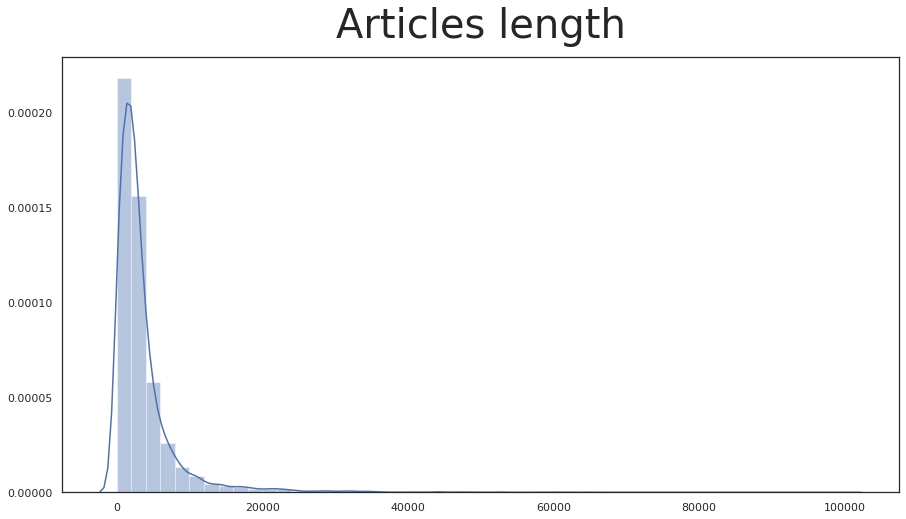

In [ ]:
df_low['length'] = df_low['text'].apply(len)
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_low['length'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Articles length (less than 5000 characters)')

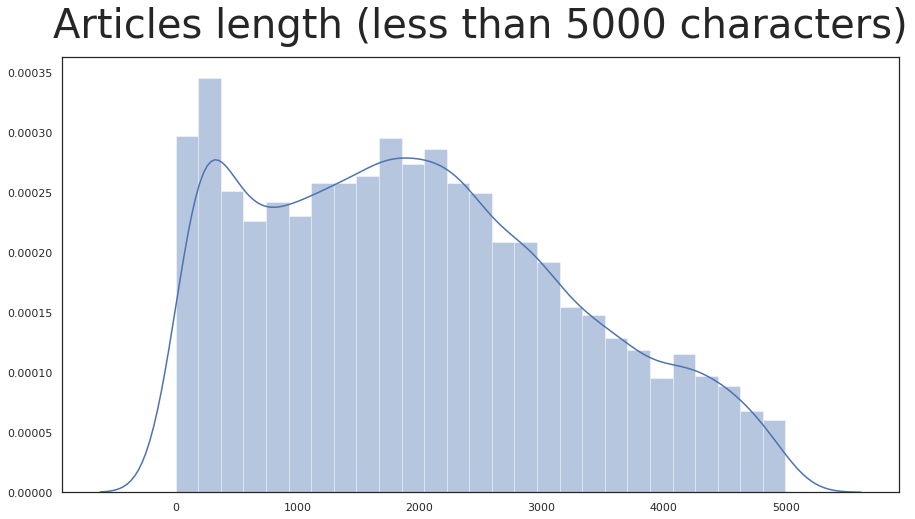

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_low[df_low['length'] < 5000]['length'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length (less than 5000 characters)', fontsize = 40, pad=20)

In [ ]:
df_low['length'].describe()

count     11080.000000
mean       3534.486913
std        4869.921926
min           3.000000
25%        1158.500000
50%        2284.500000
75%        4033.000000
max      100000.000000
Name: length, dtype: float64

In [ ]:
df_low[df_low['length'] < 100]['text'].tolist()

["Americans and the right to vote: Why it's not easy for everyone",
 'nan',
 'You might have toned your body to bring every inch of your muscle in shape. Training for...',
 'Press J to jump to the feed. Press question mark to learn the rest of the keyboard shortcuts',
 'jo promoter says wait a little bit please',
 'Notice\n\nYou must log in to continue.',
 'Help me find out what this is\n\n\n\n1 / 2',
 'Research and publish the best content.',
 'No ads, always HD experience with Gfycat Pro.',
 'Inspired by the neal.fun website by Neal Agarwal..\n\nAll Rights Reserved 2020 - 2021 ©',
 "Just a moment...\n\nWe'll try your destination again in 15 seconds",
 'Not your computer? Use Guest mode to sign in privately. Learn more',
 'Please assign a menu to the primary menu location under menu',
 "Why You Won't See 'Mrs. Dash' On the Store Shelves Anymore",
 'antifa is not an organization',
 "Chat with us in Facebook Messenger. Find out what's happening in the world as it unfolds.",
 'Like it? S

It seems that most of these short articles were just scraped on the titles or where in the form of title + images. In any case, I'd say we can keep them

In [ ]:
df_low = df_low.drop(columns=['length'], axis=1)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_low['text'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

one : 21344
like : 15229
would : 14951
said : 14853
people : 13756
time : 13350
also : 13035
new : 12927
even : 10684
get : 10511
could : 10305
first : 9331
years : 8816
us : 8605
make : 7920
may : 7874
many : 7855
two : 7542
know : 7516
way : 7447
dont : 7328
much : 7082
see : 7026
back : 6811
still : 6762
going : 6301
well : 6293
day : 6142
life : 5982
year : 5964




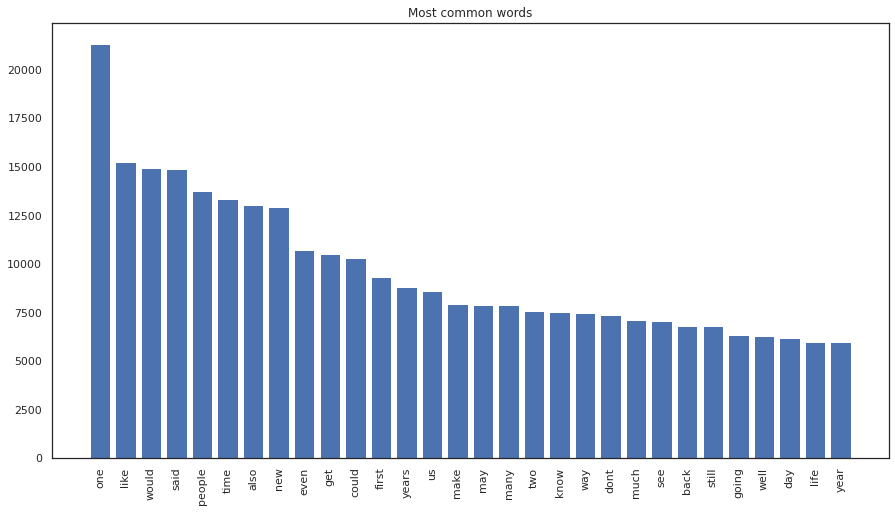

In [ ]:
plt.figure(figsize = (15,8))

names = list(mc_filtered.keys())
values = list(mc_filtered.values())

plt.bar(range(len(mc_filtered)),values,tick_label=names)
plt.title('Most common words')
plt.tick_params(axis='x', labelrotation=90)

For the moment, I'm happy with the articles we found. I'm going to add more articles coming from archive.is, which I had to scrape separately

In [ ]:
df_low.to_csv('low_quality_articles_clean.csv', index=False)
save_file_to_drive('low_quality_articles_clean.csv', 'low_quality_articles_clean.csv')

File ID: 1OGz-3i_MhpFuwzJ6d2C3JZUOXszcw5rs


{'id': '1OGz-3i_MhpFuwzJ6d2C3JZUOXszcw5rs'}

Now we go on to the high quality articles

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1HFLSC5zIQTcbghGl6Q1eRUouMQv03Br0/view?usp=sharing', 'high_quality_articles0.csv')
upload_from_drive('https://drive.google.com/file/d/1ae_K2s7kG_s0htI-t97Rjx2A-nvBc7Id/view?usp=sharing', 'high_quality_articles1.csv')
upload_from_drive('https://drive.google.com/file/d/1Oua1qqQmPCCyc3eKf176EhBUS553rhS-/view?usp=sharing', 'high_quality_articles2.csv')

In [ ]:
df_high = pd.concat([pd.read_csv('high_quality_articles0.csv'), pd.read_csv('high_quality_articles1.csv'), pd.read_csv('high_quality_articles2.csv')])

df_high = df_high.drop(columns=['publisher', 'url'], axis=1)
df_high['text'] = df_high['text'].astype(str)
df_high = df_high.drop_duplicates()
df_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11665 entries, 0 to 2877
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11665 non-null  object
dtypes: object(1)
memory usage: 182.3+ KB


Text(0.5, 1.0, 'Articles length')

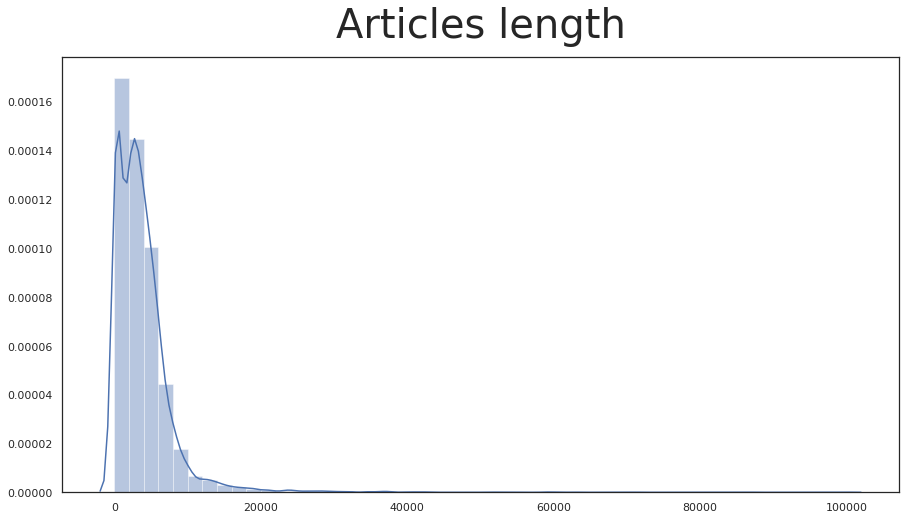

In [ ]:
df_high['length'] = df_high['text'].apply(len)
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_high['length'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Articles length (less than 5000 characters)')

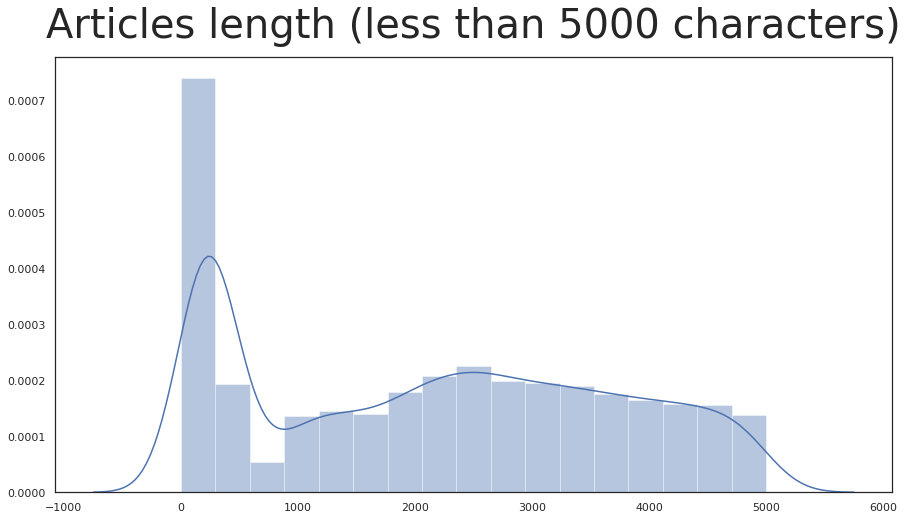

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_high[df_high['length'] < 5000]['length'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length (less than 5000 characters)', fontsize = 40, pad=20)

In [ ]:
df_high['length'].describe()

count     11665.000000
mean       3789.739048
std        4258.639953
min           3.000000
25%        1219.000000
50%        3033.000000
75%        5066.000000
max      100000.000000
Name: length, dtype: float64

In [ ]:
df_high[df_high['length'] < 100]['text'].tolist()

['nan',
 'No ads, always HD experience with Gfycat Pro.',
 'Han Kuo-yu bows to supporters after conceding defeat on Saturday. Photo: CNA',
 'You must be logged in to react.\n\nClick any reaction to login.\n\nLove 0 Funny 0 Wow 0 Sad 0 Angry 0',
 'The First Eye Implant Ever Performed\n\nViews: 18782',
 'Want to join? Log in or sign up in seconds.',
 'Trump: Fauci is a "disaster" but it would be "a bigger bomb to fire him"',
 "Americans and the right to vote: Why it's not easy for everyone",
 'What term do you want to search? Search with google',
 'It is not confirmed whether the material was indeed uranium and if so whether it was enriched.',
 'You are about to add 0 people to the discussion. Proceed with caution.',
 'The company has not said how much of its cash abroad would be brought back to the US.',
 'Argentina’s former vice president has been arrested on corruption charges.\n\nBy',
 'The Top 500 of the 70s, 80s and 90s, as voted for by you',
 'This Account has been suspended.',
 '

In this case I consider better to drop the shortest articles as they seem to be paywalls mostly

In [ ]:
df_high = df_high[df_highd['length'] > 100]

In [ ]:
df_high = df_high.drop(columns=['length'], axis=1)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_high['text'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

said : 58772
us : 24223
would : 16535
people : 16305
trump : 14852
also : 13701
one : 13514
new : 13395
government : 12982
president : 12623
state : 11504
two : 10441
police : 10268
told : 10166
could : 9353
last : 8969
states : 8566
news : 8560
years : 8319
year : 8093
says : 7649
according : 7623
time : 7275
reuters : 7226
officials : 7107
security : 7010
many : 6970
first : 6951
court : 6928
united : 6492




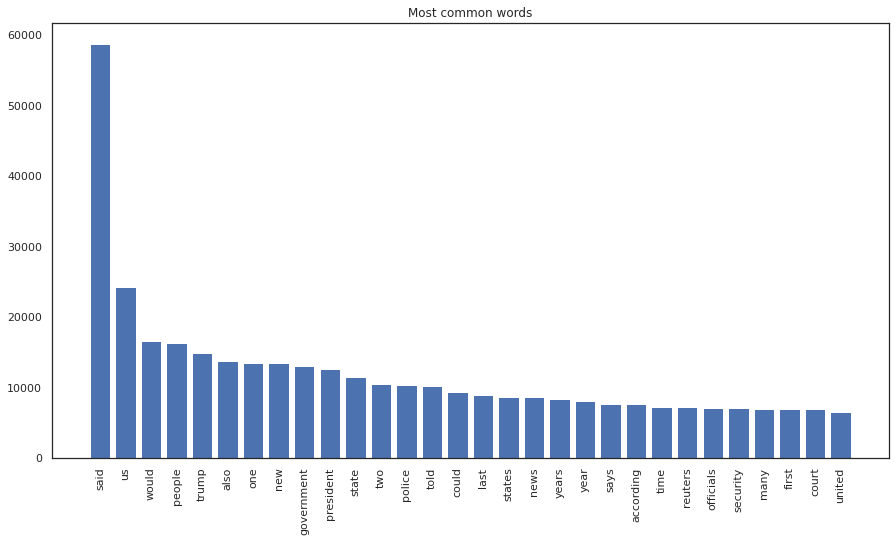

In [ ]:
plt.figure(figsize = (15,8))

names = list(mc_filtered.keys())
values = list(mc_filtered.values())

plt.bar(range(len(mc_filtered)),values,tick_label=names)
plt.title('Most common words')
plt.tick_params(axis='x', labelrotation=90)

I can say I'm happy with the high quality articles as well. We can proceed to train the models. To be noted that we will have to find new sources if I manage to scrape more low quality articles

In [ ]:
df_low['high_quality'] = 0
df_high['high_quality'] = 1
df_final = pd.concat([df_low, df_high])
df_final.to_csv('professional_news_dataset.csv', index=False)
save_file_to_drive('professional_news_dataset.csv', 'professional_news_dataset.csv')

File ID: 1HMMQWbsQ5A6e9M89jMl-xl4FU7ywsH72


{'id': '1HMMQWbsQ5A6e9M89jMl-xl4FU7ywsH72'}

#### Second try

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1easWKFpDhJhvQzQirqd1XGW-OiI4MA2j/view?usp=sharing','low_quality_articles0.csv')
upload_from_drive('https://drive.google.com/file/d/1Ze3-ly3NZ-gd2Ray7t_FyIdpzcBeGOAc/view?usp=sharing','low_quality_articles1.csv')
upload_from_drive('https://drive.google.com/file/d/1EHF2BAsD2SWycLza7drc7RiAbjIzCZr4/view?usp=sharing','low_quality_articles2.csv')
upload_from_drive('https://drive.google.com/file/d/1YkUQa-rRO_ykUoSkeo_a-YU2TlapaUac/view?usp=sharing','low_quality_articles3.csv')
upload_from_drive('https://drive.google.com/file/d/1bCIWMVuU13CHJUQUdSTEyqjtVFit4AXc/view?usp=sharing','low_quality_articles4.csv')
upload_from_drive('https://drive.google.com/file/d/1TnrUQJKfDWTxXqx8PHsoVFCVEZyNZV7E/view?usp=sharing','low_quality_articles5.csv')

In [ ]:
df_low = pd.DataFrame()
for i in range(0,6):
  df_low = pd.concat([df_low, pd.read_csv('low_quality_articles' + str(i) + '.csv')])

df_low = df_low.drop(columns=['publisher', 'url'], axis=1)
df_low['text'] = df_low['text'].astype(str)
df_low = df_low.drop_duplicates()
df_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11080 entries, 0 to 334
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11080 non-null  object
dtypes: object(1)
memory usage: 173.1+ KB


In [ ]:
upload_from_drive('https://drive.google.com/file/d/1fw7nWRBn5ssLUjd2A2R-CREzeqZptroD/view?usp=sharing', 'high_quality_articles_second_0.csv')
upload_from_drive('https://drive.google.com/file/d/1Ai5vV2m9rTauM_LYMnrNt4FM1RBXByHP/view?usp=sharing', 'high_quality_articles_second_1.csv')
upload_from_drive('https://drive.google.com/file/d/1bP-qE5kwmUKX0To40PMDFI2baQxhT-eA/view?usp=sharing', 'high_quality_articles_second_2.csv')
upload_from_drive('https://drive.google.com/file/d/1lQjDTsMf-EgIyyaNil0N9P5UeiSDfqlG/view?usp=sharing', 'high_quality_articles_second_3.csv')
upload_from_drive('https://drive.google.com/file/d/1rBeGJiLrlj-4OT8ez06DDzyHyN8H6Eet/view?usp=sharing', 'high_quality_articles_second_4.csv')
upload_from_drive('https://drive.google.com/file/d/1u_LJ1E4c_ZjLVABy6ySUtyId23zx4AcG/view?usp=sharing', 'high_quality_articles_second_5.csv')

In [ ]:
df_high = pd.DataFrame()
for i in range(0,6):
  df_high = pd.concat([df_high, pd.read_csv('high_quality_articles_second_' + str(i) + '.csv')])

df_high = df_high.drop(columns=['publisher', 'url'], axis=1)
df_high['text'] = df_high['text'].astype(str)
df_high = df_high.drop_duplicates()
df_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17569 entries, 0 to 4316
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17569 non-null  object
dtypes: object(1)
memory usage: 274.5+ KB


For the moment we sample the high quality dataset

In [ ]:
df_high = df_high.sample(n=11000)

In [ ]:
df_low['is_high_quality'] = 0
df_high['is_high_quality'] = 1
df_final = pd.concat([df_low, df_high])

In [ ]:
df_final.to_csv('professional_news_dataset_second.csv', index=False)
save_file_to_drive('professional_news_dataset_second.csv', 'professional_news_dataset_second.csv')

File ID: 1Rjuqd4BywuJ6dSptRTJXiBqtH8-YoPSP


{'id': '1Rjuqd4BywuJ6dSptRTJXiBqtH8-YoPSP'}

#### Third try

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1easWKFpDhJhvQzQirqd1XGW-OiI4MA2j/view?usp=sharing','low_quality_articles0.csv')
upload_from_drive('https://drive.google.com/file/d/1Ze3-ly3NZ-gd2Ray7t_FyIdpzcBeGOAc/view?usp=sharing','low_quality_articles1.csv')
upload_from_drive('https://drive.google.com/file/d/1EHF2BAsD2SWycLza7drc7RiAbjIzCZr4/view?usp=sharing','low_quality_articles2.csv')
upload_from_drive('https://drive.google.com/file/d/1YkUQa-rRO_ykUoSkeo_a-YU2TlapaUac/view?usp=sharing','low_quality_articles3.csv')
upload_from_drive('https://drive.google.com/file/d/1bCIWMVuU13CHJUQUdSTEyqjtVFit4AXc/view?usp=sharing','low_quality_articles4.csv')
upload_from_drive('https://drive.google.com/file/d/1TnrUQJKfDWTxXqx8PHsoVFCVEZyNZV7E/view?usp=sharing','low_quality_articles5.csv')

In [ ]:
df_low = pd.DataFrame()
for i in range(0,6):
  df_low = pd.concat([df_low, pd.read_csv('low_quality_articles' + str(i) + '.csv')])

df_low = df_low.drop(columns=['publisher', 'url'], axis=1)
df_low['text'] = df_low['text'].astype(str)
df_low = df_low.drop_duplicates()
df_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11080 entries, 0 to 334
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11080 non-null  object
dtypes: object(1)
memory usage: 173.1+ KB


In [ ]:
upload_from_drive('https://drive.google.com/file/d/1tw4kiikVptTxoEo9tPXLB07bj5MJGg7x/view?usp=sharing', 'high_quality_articles_third.csv')

In [ ]:
df_high = pd.read_csv('high_quality_articles_third.csv')
df_high['text'] = df_high['text'].astype(str)
df_high = df_high.drop(columns=['url'], axis=1)
df_high.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15437 entries, 0 to 15436
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15437 non-null  object
dtypes: object(1)
memory usage: 120.7+ KB


In [ ]:
df_low['is_high_quality'] = 0
df_high['is_high_quality'] = 1
df = pd.concat([df_low, df_high])

## Model training
Now that the datasets have been created, we can start training a BERT model on them. At this time, I'm still downloading separately some of the articles, so I will divide the training in two sections: one with a smaller dataset that I have available now, then with a bigger complete dataset

### First try: r/qualitynews

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1HMMQWbsQ5A6e9M89jMl-xl4FU7ywsH72/view?usp=sharing','professional_news_dataset.csv')
df = pd.read_csv('professional_news_dataset.csv')

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df, 
                                                                   text_column='text',
                                                                   label_columns=["high_quality"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=5)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
757/757 [==============================] - 330s 436ms/step - loss: 0.5118 - accuracy: 0.7328
Epoch 2/5
757/757 [==============================] - 328s 434ms/step - loss: 0.2050 - accuracy: 0.9221
Epoch 3/5
757/757 [==============================] - 326s 431ms/step - loss: 0.6810 - accuracy: 0.5908
Epoch 4/5
757/757 [==============================] - 324s 429ms/step - loss: 0.9673 - accuracy: 0.4998


done.
Visually inspect loss plot and select learning rate associated with falling loss


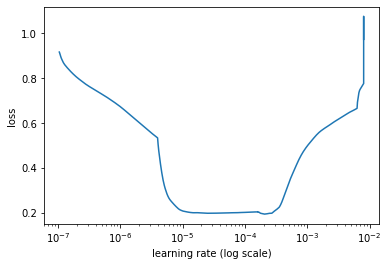

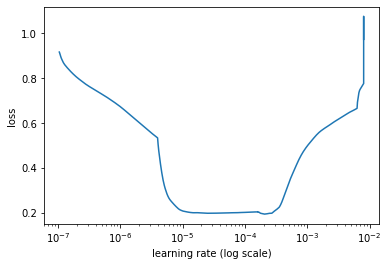

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.freeze()
learner.fit_onecycle(5e-4, 4)



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/4
757/757 [==============================] - 82s 108ms/step - loss: 0.5527 - accuracy: 0.7386 - val_loss: 0.4125 - val_accuracy: 0.8443
Epoch 2/4
757/757 [==============================] - 78s 103ms/step - loss: 0.3602 - accuracy: 0.8633 - val_loss: 0.3098 - val_accuracy: 0.8796
Epoch 3/4
757/757 [==============================] - 78s 103ms/step - loss: 0.2987 - accuracy: 0.8864 - val_loss: 0.2822 - val_accuracy: 0.8919
Epoch 4/4
757/757 [==============================] - 78s 103ms/step - loss: 0.2801 - accuracy: 0.8916 - val_loss: 0.2770 - val_accuracy: 0.8950


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2249
           1       0.88      0.91      0.90      2293

    accuracy                           0.89      4542
   macro avg       0.90      0.89      0.89      4542
weighted avg       0.90      0.89      0.89      4542



array([[1968,  281],
       [ 196, 2097]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
predictor.save('professionality_detector_first')
save_file_to_drive('tf_model_first.h5', 'professionality_detector_first/tf_model.h5')
save_file_to_drive('tf_model_first.preproc', 'professionality_detector_first/tf_model.preproc')

File ID: 1eLSgCQ8jgxdyRrszjCK2D_DX_Wg74PWt
File ID: 1eyr7VsZ0XHNhQIHKprGFqiyqh6ri4m-Q


{'id': '1eyr7VsZ0XHNhQIHKprGFqiyqh6ri4m-Q'}

### Second try: r/news

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1Rjuqd4BywuJ6dSptRTJXiBqtH8-YoPSP/view?usp=sharing','professional_news_dataset_second.csv')
df = pd.read_csv('professional_news_dataset_second.csv')

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df, 
                                                                   text_column='text',
                                                                   label_columns=["is_high_quality"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=5,
                                                                   lang='en')

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
736/736 [==============================] - 429s 582ms/step - loss: 0.5591 - accuracy: 0.7115
Epoch 2/5
736/736 [==============================] - 427s 580ms/step - loss: 0.3352 - accuracy: 0.8547
Epoch 3/5
736/736 [==============================] - 427s 581ms/step - loss: 0.6971 - accuracy: 0.5757
Epoch 4/5
736/736 [==============================] - 427s 581ms/step - loss: 1.8289 - accuracy: 0.5057


done.
Visually inspect loss plot and select learning rate associated with falling loss


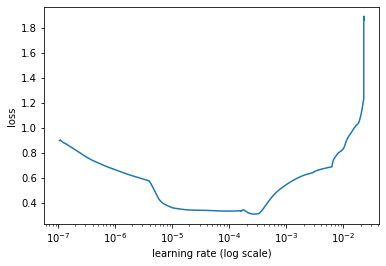

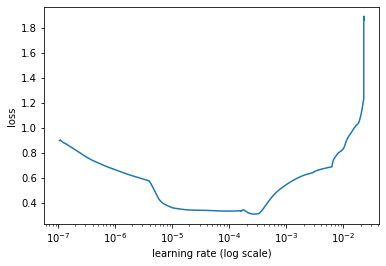

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot()

In [ ]:
#Fit model
learner.freeze()
learner.fit_onecycle(5e-4, 1)



begin training using onecycle policy with max lr of 0.0005...
736/736 [==============================] - 78s 106ms/step - loss: 0.5578 - accuracy: 0.7350 - val_loss: 0.4871 - val_accuracy: 0.7812


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2203
           1       0.80      0.75      0.78      2213

    accuracy                           0.78      4416
   macro avg       0.78      0.78      0.78      4416
weighted avg       0.78      0.78      0.78      4416



array([[1780,  423],
       [ 543, 1670]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
predictor.save('professionality_detector_second')
save_file_to_drive('tf_model_second.h5', 'professionality_detector_second/tf_model.h5')
save_file_to_drive('tf_model_second.preproc', 'professionality_detector_second/tf_model.preproc')

File ID: 1EKkAwa-yG3QzRvPeWZyPrznhhduGNDIi
File ID: 1iyMsn7s_8TBoEcoVwEpL4-cgtqd62R-g


{'id': '1iyMsn7s_8TBoEcoVwEpL4-cgtqd62R-g'}

### Third try: selected publishers

In [ ]:
#Preprocess text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=df, 
                                                                   text_column='text',
                                                                   label_columns=["is_high_quality"],
                                                                   val_pct=0.2, 
                                                                   max_features=100000, 
                                                                   maxlen=128,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=5)

#Build learner
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 128
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
884/884 [==============================] - 393s 445ms/step - loss: 0.4989 - accuracy: 0.7539
Epoch 2/5
884/884 [==============================] - 393s 445ms/step - loss: 0.2457 - accuracy: 0.9035
Epoch 3/5
884/884 [==============================] - 393s 445ms/step - loss: 0.6516 - accuracy: 0.6317
Epoch 4/5
884/884 [==============================] - 393s 445ms/step - loss: 1.8074 - accuracy: 0.5188


done.
Visually inspect loss plot and select learning rate associated with falling loss


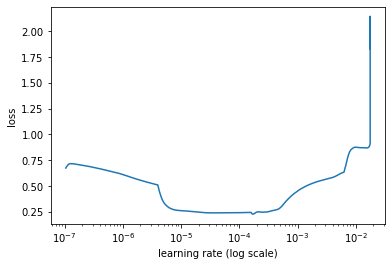

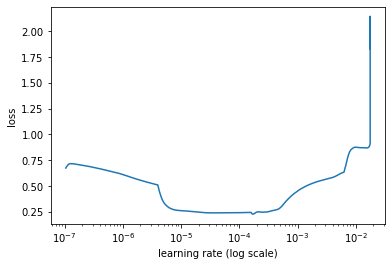

In [ ]:
#Find optimal learning rate
learner.lr_find(show_plot=True, max_epochs=5)
learner.lr_plot() 

In [ ]:
#Fit model
learner.freeze()
learner.fit_onecycle(5e-4, 4)



begin training using onecycle policy with max lr of 0.0005...
Epoch 1/4
884/884 [==============================] - 96s 109ms/step - loss: 0.5948 - accuracy: 0.6956 - val_loss: 0.4991 - val_accuracy: 0.7979
Epoch 2/4
884/884 [==============================] - 93s 105ms/step - loss: 0.4531 - accuracy: 0.8110 - val_loss: 0.4045 - val_accuracy: 0.8394
Epoch 3/4
884/884 [==============================] - 93s 105ms/step - loss: 0.3957 - accuracy: 0.8366 - val_loss: 0.3839 - val_accuracy: 0.8435
Epoch 4/4
884/884 [==============================] - 93s 105ms/step - loss: 0.3791 - accuracy: 0.8439 - val_loss: 0.3668 - val_accuracy: 0.8497


In [ ]:
#Validate
learner.validate()

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2206
           1       0.86      0.88      0.87      3098

    accuracy                           0.85      5304
   macro avg       0.85      0.84      0.84      5304
weighted avg       0.85      0.85      0.85      5304



array([[1776,  430],
       [ 367, 2731]])

In [ ]:
#Get predictor
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
predictor.save('professionality_detector')

In [ ]:
save_file_to_drive('tf_model.h5', 'professionality_detector/tf_model.h5')
save_file_to_drive('tf_model.preproc', 'professionality_detector/tf_model.preproc')

File ID: 1JjqbWyr3sFBr6Pd7WD3uQ81466KpZtMB
File ID: 1l2fR3DwdqVcK1sttX5bBUg1eIVXzh0a6


{'id': '1l2fR3DwdqVcK1sttX5bBUg1eIVXzh0a6'}